In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip as sigmaclip
from scipy.interpolate import interp1d
import astropy.constants as const
from tqdm.notebook import tnrange
from scipy.optimize import curve_fit

from function import med_n_lim

import warnings
warnings.filterwarnings('ignore')

In [4]:
def cc(func_telluric,continum_minimum):

    # reading SYSREM results

    numorder, numframe, numwv, n_sys = 22, 56, 4080, 15

    #for propagation error
    flux_data = np.zeros((numorder,n_sys+1,numframe,numwv))
    error_data = flux_data.copy()
    wave_data = flux_data.copy()
    a_data = np.zeros((numorder,n_sys+1,numframe))
    c_data = np.zeros((numorder,n_sys+1,numwv))

    for order in range(numorder):
        for sysiter in range(n_sys+1):

        #reading hdf5 file for each SYSREM iteration
            with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys-continuum_'+str(continum_minimum)+'eta_'+str(func_telluric)+'.hdf5', 'r') as h5f_raw:
            # with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys.hdf5', 'r') as h5f_raw:
                flux_data[order,sysiter] = h5f_raw['flux-order-'+str(order)][()]
                error_data[order,sysiter] = h5f_raw['error-poisson-order-'+str(order)][()]
                wave_data[order,sysiter] = h5f_raw['wv-vac-order-'+str(order)][()]
                airmass = h5f_raw['airmass'][()]
                rvcor = h5f_raw['rv_cor'][()]
                bjd = h5f_raw['bjd'][()]
                mjd = h5f_raw['mjd'][()]
                phase = h5f_raw['phase'][()]
                rel_phase = h5f_raw['rel_phase'][()]
                hour_phase = h5f_raw['hour_phase'][()]
                exptime = h5f_raw['exp_time'][()]
                out_transit_mask = h5f_raw['out_transit_mask'][()]
                transit_weight = h5f_raw['transit_weight'][()]
                carm_order = h5f_raw['carm_order'][()]
                contact_index = h5f_raw['contact_index'][()]

                if sysiter != 0:
                    a_data[order,sysiter-1] = h5f_raw['a-coeff-order-'+str(order)][()]
                    c_data[order,sysiter-1] = h5f_raw['c-coeff-order-'+str(order)][()]

    def kpvsys_calc(Kp, Vsys, RV, data, vsys_planet, orb_phase, RV_bary, mask, v_phase, eccentric=False):

        """
        Interpolate CCF values to a range of Kp and Vsys

        Args:
            kp          : K_p sample in km/s
            vsys        : V_sys sample in km/s
            drvs        : RV sample in km/s
            data        : Cross-correlation values to be interpolated (frame x RV)
            vsys_planet : The expected V_sys of the planet
            orb_phase   : Orbital phase of the planet
            brv         : Correction for barycentric velocity
            mask        : A mask for out-transit frames

        Return:
            summed      : Interpolated CCF values
        """

        data = data[mask]
        orb_phase = orb_phase[mask]
        RV_bary = RV_bary[mask]

        kpvsys_frame = np.zeros([Kp.size] + [data.shape[0]] + [Vsys.size])
        for kp_idx,kp in enumerate(Kp):

            # aligning the in-trail CCF to the planetary rest-frame (Vsys ~ 0 km/s)
            if not eccentric: RV_predict = kp * np.sin(2. * np.pi * orb_phase) + RV_bary + vsys_planet

            for phase_idx in range(orb_phase.size):
                kpvsys_frame[kp_idx,phase_idx] = interp1d(RV,data[phase_idx],kind='linear')(RV_predict[phase_idx] + Vsys)

        kpvsys_map = kpvsys_frame.sum(axis=1)
        return kpvsys_map

    def fitting_histogram(distribution,plot=True):

        # making the histogram
        num_bins = int(1 + 3.322*np.log10(len(distribution))) # following Sturge's rule
        hist_ = plt.hist(distribution,histtype="step",align='mid',bins=num_bins)

        # assigning the value of each bin and the x-axis of the bin itself ~ (right_edge+left_edge)/2
        x_hist_edges,y_hist = hist_[1],hist_[0]
        x_hist = (x_hist_edges[:-1] + x_hist_edges[1:])/2

        # calculating the Gaussian PDF values given Gaussian parameters and random variable X
        def gaus(X, C, X_mean, sigma):
            return C * np.exp(-(X - X_mean)**2 / (2 * sigma**2))
        
        # calculate the mean and standard deviation
        # the standard deviation is the square root of the variance of the distribution, which is defined as the average of the squared differences of the data from the mean.
        mean = sum(x_hist * y_hist) / sum(y_hist)
        sigma = sum(y_hist * (x_hist-mean)**2) / sum(y_hist)

        # Gaussian least-square fitting process
        # the constant C is just a normalization factor, so we can use the maximum value of the distribution
        param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

        # plotting the histogram
        if plot:
            plt.hist(distribution,histtype="step",align='mid',bins=num_bins)
            plt.plot(x_hist,y_hist,label='data')
            plt.plot(x_hist,gaus(x_hist,*param_optimised),label='fit')
            plt.legend()
            plt.show()
            plt.clf()

        # print fit Gaussian parameters
        print("Fit parameters: ")
        print("=====================================================")
        print("C = ", param_optimised[0], "+-", np.sqrt(param_covariance_matrix[0, 0]))
        print("X_mean =", param_optimised[1], "+-", np.sqrt(param_covariance_matrix[1, 1]))
        print("sigma = ", param_optimised[2], "+-", np.sqrt(param_covariance_matrix[2, 2]))
        print("\n")

        return np.abs(param_optimised[2])

    # function for cross-correlating model with data, creating Kp-Vsys map, and calculating log-likelihood  mapping
    def detect_molecules(wavedat, fluxdat, errordat, wave_modelmol, flux_modelmol,
                        sysrem_iteration, carm_order,
                        RV_sample, Kp_sample, Vsys_sample, A_sample,
                        Kp_planet, Vsys_planet,
                        transit_weight, out_transit_mask, rvcor, phase,
                        std_brogi=True, eccentric=False, plot=True, 
                        thold_kp=150, thold_vsys=10, dpi=100, neg_Kp=False):

        CC_total_norm_final = []
        CC_shifted_final = []
        CC_combine_final = []
        SN_map_final = []
        SN_map_final_std = []
        Likelihood_F_final = []
        for sys_iter in range(sysrem_iteration):

            if sys_iter != 0:

                # print('################ SYSREM '+str(sys_iter)+' #####################')
                
                K1_all,K2_all,CC_all,N_data = [],[],[],[]
                for idx in range(len(carm_order)):

                    flux_obs = fluxdat[idx][sys_iter].copy()
                    wave_obs = wavedat[idx][sys_iter].copy()
                    error_obs = errordat[idx][sys_iter].copy()

                    # masking model to the corresponding order wavelength
                    masktemp = (wave_modelmol > wave_obs[0][0] - 20) * (wave_modelmol < wave_obs[0][-1] + 20)
                    wave_mod,flux_mod = wave_modelmol[masktemp],flux_modelmol[masktemp]

                    # Doppler-shift the model (RV_sample x wavelength)
                    wave_mod_shifted = wave_obs[0][np.newaxis,:] / (1 + RV_sample*1000/const.c.value)[:,np.newaxis]
                    flux_mod_shifted = np.interp(wave_mod_shifted,wave_mod,flux_mod)

                    # putting the Doppler-shifted model into common continuum level
                    flux_mod_shifted -= np.nanmedian(flux_mod_shifted,axis=1)[:,np.newaxis]
                    maskpix = error_obs[0]!=np.inf
                    for frame in range(error_obs.shape[0]):
                        flux_obs[frame][maskpix==True] = flux_obs[frame][maskpix] - np.nanmedian(flux_obs[frame][maskpix])

                    # calculating the summation terms in the chi^2 equation
                    K1 = np.nansum(flux_obs**2/error_obs**2,axis=1)
                    K2 = np.dot(1./error_obs**2,(flux_mod_shifted**2).T)
                    CC = np.dot(flux_obs/error_obs**2,flux_mod_shifted.T)

                    K1_all.append(K1)
                    K2_all.append(K2)
                    CC_all.append(CC)

                    # computing total data points N including masked pixels
                    N_data.append(len(wave_obs[0]))

                # summing over orders
                K1_total = np.sum(K1_all,axis=0)
                K2_total = np.sum(K2_all,axis=0)
                CC_total = np.sum(CC_all,axis=0)
                Ndata_total = np.sum(N_data)

                # normalizing
                CC_total_norm = CC_total - np.nanmedian(CC_total,axis=1)[:,np.newaxis]

                # expected RV path
                v_phase = phase.copy()
                if not eccentric: RV_planet = Kp_planet * np.sin(2. * np.pi * phase) + (-rvcor) + Vsys_planet

                # shifting to planetary rest frame
                CC_shifted = np.zeros([phase.size] + [Vsys_sample.size])
                for frame in range (phase.size):
                    CC_shifted[frame] = interp1d(RV_sample,CC_total_norm[frame])(RV_planet[frame] + Vsys_sample)
                
                # combine weighted values over time
                CC_combine = np.sum(CC_shifted * transit_weight[:,np.newaxis], axis=0)

                CC_total_norm_final.append(CC_total_norm)
                CC_shifted_final.append(CC_shifted)
                CC_combine_final.append(CC_combine)

                ################################## Kp-Vsys Map ##################################

                # CC for Kp-Vsys map (must be normalised)
                CC_all_kpvsys_norm = kpvsys_calc(Kp_sample,Vsys_sample,RV_sample,CC_total_norm*transit_weight[:,np.newaxis]\
                                ,Vsys_planet,np.array(phase),-np.array(rvcor),out_transit_mask>0,v_phase,eccentric=eccentric)
                
                # index of maximum value in the Kp-Vsys map
                kp_snmax,vsys_snmax = np.unravel_index(CC_all_kpvsys_norm.argmax(),CC_all_kpvsys_norm.shape)

                # masking the maximum signal in the map (+-thold)
                masked_peak = CC_all_kpvsys_norm != np.inf
                kp_maskpeak = np.digitize([Kp_sample[kp_snmax] - thold_kp, Kp_sample[kp_snmax] + thold_kp], Kp_sample)
                vsys_maskpeak = np.digitize([Vsys_sample[vsys_snmax] - thold_vsys, Vsys_sample[vsys_snmax] + thold_vsys], Vsys_sample)
                masked_peak[kp_maskpeak[0]:kp_maskpeak[-1],vsys_maskpeak[0]:vsys_maskpeak[-1]] = False

                # masking telluric region Kp ~ 0-50 km/s for all Vrest
                if not neg_Kp:
                    kp_tel = (np.abs(Kp_sample - 50)).argmin()
                    masked_peak[:kp_tel,:] = False
                else:
                    kp_tel = (np.abs(Kp_sample + 50)).argmin()
                    masked_peak[kp_tel:,:] = False
                
                # choosing between using std calculation from Brogi or the conventional
                if not std_brogi:
                    # map_std = kpvsys_sigma_conventional(CC_all_kpvsys_norm,Kp_sample,Vsys_sample,kp_snmax,vsys_snmax,kp_negative)
                    map_std = np.std(CC_all_kpvsys_norm[masked_peak])
                else:
                    map_std = fitting_histogram(CC_all_kpvsys_norm[masked_peak],plot=plot)

                SN_map = CC_all_kpvsys_norm / map_std
                SN_map_final.append(SN_map)
                # SN_map_final.append(CC_all_kpvsys_norm)
                # SN_map_final_std.append(map_std)
                # index of the location of the expected planet location

                vsys_expect = (np.abs(Vsys_sample - 0)).argmin() # since the Kp-Vsys map is in the planet rest-frame (see the kpvsys_calc function)
                kp_expect = (np.abs(Kp_sample - Kp_planet)).argmin()

                colorm = 'viridis'
                cmap = plt.get_cmap(colorm)
                cmap.set_bad(color = 'white', alpha = 1.)
                
                def kpvsys_plot(kpvsys,label,vmax=vsys_snmax,kmax=kp_snmax,shade=False):

                    axes_kpvsysmap = [0, 0, 0.5, 0.5]
                    axes_vsyscurve = [0, 0 + 0.5, 0.5, 0.2]
                    axes_kpcurve = [0 + 0.5, 0, 0.2, 0.5]

                    fig = plt.figure(figsize=(7, 6))
                    kpvsysmap = plt.axes(axes_kpvsysmap)
                    kpcurve = plt.axes(axes_kpcurve)
                    vsyscurve = plt.axes(axes_vsyscurve)

                    SN_mapcolorbar = kpvsysmap.pcolormesh(Vsys_sample, Kp_sample, kpvsys, cmap=cmap)
                    kpvsysmap.set_xlabel("V$_{sys}$ (km/s)")
                    kpvsysmap.set_ylabel("K$_{p}$ (km/s)")
                    gap = 30
                    # vertical lines
                    kpvsysmap.plot((Vsys_sample[vmax], Vsys_sample[vmax]), (Kp_sample[0], Kp_sample[kmax] - gap), ls='--',
                                color='white', alpha=1, lw=1)
                    kpvsysmap.plot((Vsys_sample[vmax], Vsys_sample[vmax]), (Kp_sample[-1], Kp_sample[kmax] + gap), ls='--',
                                color='white', alpha=1, lw=1)
                    # horizontal lines
                    kpvsysmap.plot((Vsys_sample[0], Vsys_sample[vmax] - gap), (Kp_sample[kmax], Kp_sample[kmax]), ls='--',
                                color='white', alpha=1, lw=1)
                    kpvsysmap.plot((Vsys_sample[-1], Vsys_sample[vmax] + gap), (Kp_sample[kmax], Kp_sample[kmax]), ls='--',
                                color='white', alpha=1, lw=1)
                    kpvsysmap.plot(Vsys_sample[vmax],Kp_sample[kmax],'x',c='magenta')
                    kpvsysmap.plot(Vsys_sample[vsys_expect],Kp_sample[kp_expect],'+',c='cyan')
                    kpvsysmap.set_ylim([min(Kp_sample), max(Kp_sample)])
                    kpvsysmap.set_xlim([min(Vsys_sample), max(Vsys_sample)])
                    plt.colorbar(SN_mapcolorbar, label=label, ax=kpcurve)

                    if shade:
                        kpvsysmap.fill_between(Vsys_sample[vsys_maskpeak[0]:vsys_maskpeak[-1]],Kp_sample[kp_maskpeak[0]],Kp_sample[kp_maskpeak[-1]-1],alpha=0.05,color='white')

                    # Kp and Vsys curves are taken from the maximum S/N in the map
                    kpcurve.plot(kpvsys[:, vmax], Kp_sample)
                    kpcurve.set_xlabel(label)
                    kpcurve.set_yticklabels([])
                    kpcurve.axhline(y=Kp_sample[kmax], ls='--')
                    kpcurve.set_ylim([min(Kp_sample), max(Kp_sample)])

                    vsyscurve.plot(Vsys_sample, kpvsys[kmax, :])
                    vsyscurve.set_ylabel(label)
                    vsyscurve.set_xticklabels([])
                    vsyscurve.axvline(x=Vsys_sample[vmax], ls='--')
                    vsyscurve.set_xlim([min(Vsys_sample), max(Vsys_sample)])

                    plt.show(block=False)
                    plt.clf()

                if plot: kpvsys_plot(SN_map,"S/N")

                # print('SYSREM '+str(str(sys_iter)))
                # print('')
                # print('Max. peak from S/N map:')
                # print('Kp = '+str(Kp_sample[kp_snmax])+' km/s')
                # print('Vsys = '+str(Vsys_sample[vsys_snmax])+' km/s')
                # print('S/N = '+str(round(SN_map[kp_snmax,vsys_snmax],2)))

        return SN_map_final, SN_map_final_std
    
    # reading model
    flux_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_flux_woRotBroad.pkl')
    wave_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_wave_woRotBroad.pkl')

    RV_sample = np.arange(-350,350,1.30)    # in km/s
    Kp_sample = np.arange(0,300,2.0)       # in km/s
    Vsys_sample = np.arange(-120,120,0.5)       # in km/s
    Kp_planet = 164.27                          # in km/s (calculated from formula given in Exoplanets (Seager, 2010))
    Vsys_planet = -17.92                        # in km/s (calculated from stellar RV analysis)
    A_sample = np.arange(-5.,5.,0.01)
    sys_num = 15

    wvdat,fluxdat,errdat = wave_data,flux_data,error_data
    snmap_h2o,snmap_h2o_std, = detect_molecules(wvdat,fluxdat,errdat,wave_modelmol,flux_modelmol,sys_num+1,carm_order,
                    RV_sample,Kp_sample,Vsys_sample,A_sample,
                    Kp_planet,Vsys_planet,transit_weight,out_transit_mask,rvcor,phase,std_brogi=True,eccentric=False,plot=False)
    
    return snmap_h2o

Fit parameters: 
C =  8223.26425602859 +- 195.6285245524355
X_mean = -0.6808807245557513 +- 0.13160532362398694
sigma =  -4.793224599024362 +- 0.1320299241342553


Fit parameters: 
C =  8473.508387912787 +- 210.74242607058255
X_mean = -0.6322995575262689 +- 0.13078684356339054
sigma =  -4.5552727975796365 +- 0.13095908887194269


Fit parameters: 
C =  8078.927436890586 +- 161.27953146584827
X_mean = -0.48238877169510297 +- 0.10389856394556035
sigma =  4.509144415013121 +- 0.10415438752860003


Fit parameters: 
C =  8472.390742027445 +- 113.88287250436449
X_mean = -0.6678636755351155 +- 0.06577205997202538
sigma =  4.239136609475428 +- 0.06591917923161127


Fit parameters: 
C =  8254.37072535516 +- 74.53894444167898
X_mean = -0.7091660139552597 +- 0.04335772147000754
sigma =  4.1594048257265195 +- 0.04343116753088697


Fit parameters: 
C =  8054.664397708663 +- 102.38452983069368
X_mean = -0.3941385704394001 +- 0.05726960992355827
sigma =  -3.9033955166149146 +- 0.05740030239075235


Fi

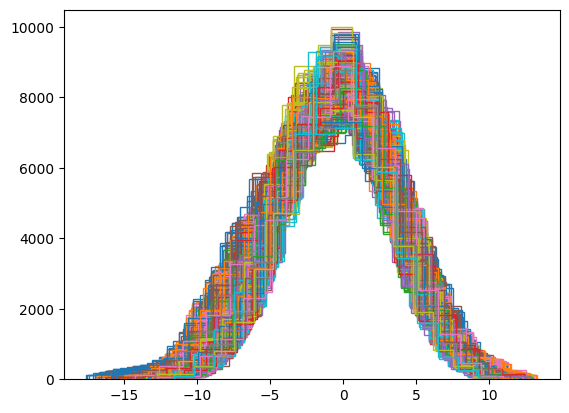

In [5]:
factel = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,29,30]
continum_minimum = [0.2,0.3]
sig20 = []
sig30 = []
for i in factel:
    sig20.append(cc(i,continum_minimum[0]))
    sig30.append(cc(i,continum_minimum[1]))

In [6]:
# run the following also for 30% continuum: sig30
Kp_sample = np.arange(0,300,2.0)            # in km/s
Vsys_sample = np.arange(-120,120,0.5)              # in km/s
sys_num = 15
factel = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,29,30]
sigeta20 = np.zeros((len(factel),sys_num))
sigeta30 = np.zeros((len(factel),sys_num))
for i in range(len(factel)):
    for j in range(sys_num):
        sigeta20[i,j] = (sig20[i][j][(np.abs(Kp_sample - 160.0)).argmin(),(np.abs(Vsys_sample - 2.5)).argmin()])
        sigeta30[i,j] = (sig30[i][j][(np.abs(Kp_sample - 160.0)).argmin(),(np.abs(Vsys_sample - 2.5)).argmin()])

# sigeta20[13][10] = np.median(sigeta20[:,10])
# sigeta20[10][12] = np.median(sigeta20[:,12])
# sigeta20[4][12] = np.median(sigeta20[:,12])

In [9]:
sigeta30[10,-2] = np.median(sigeta30[:,-2])
sigeta20[8,-1]= np.median(sigeta20[:,-1])

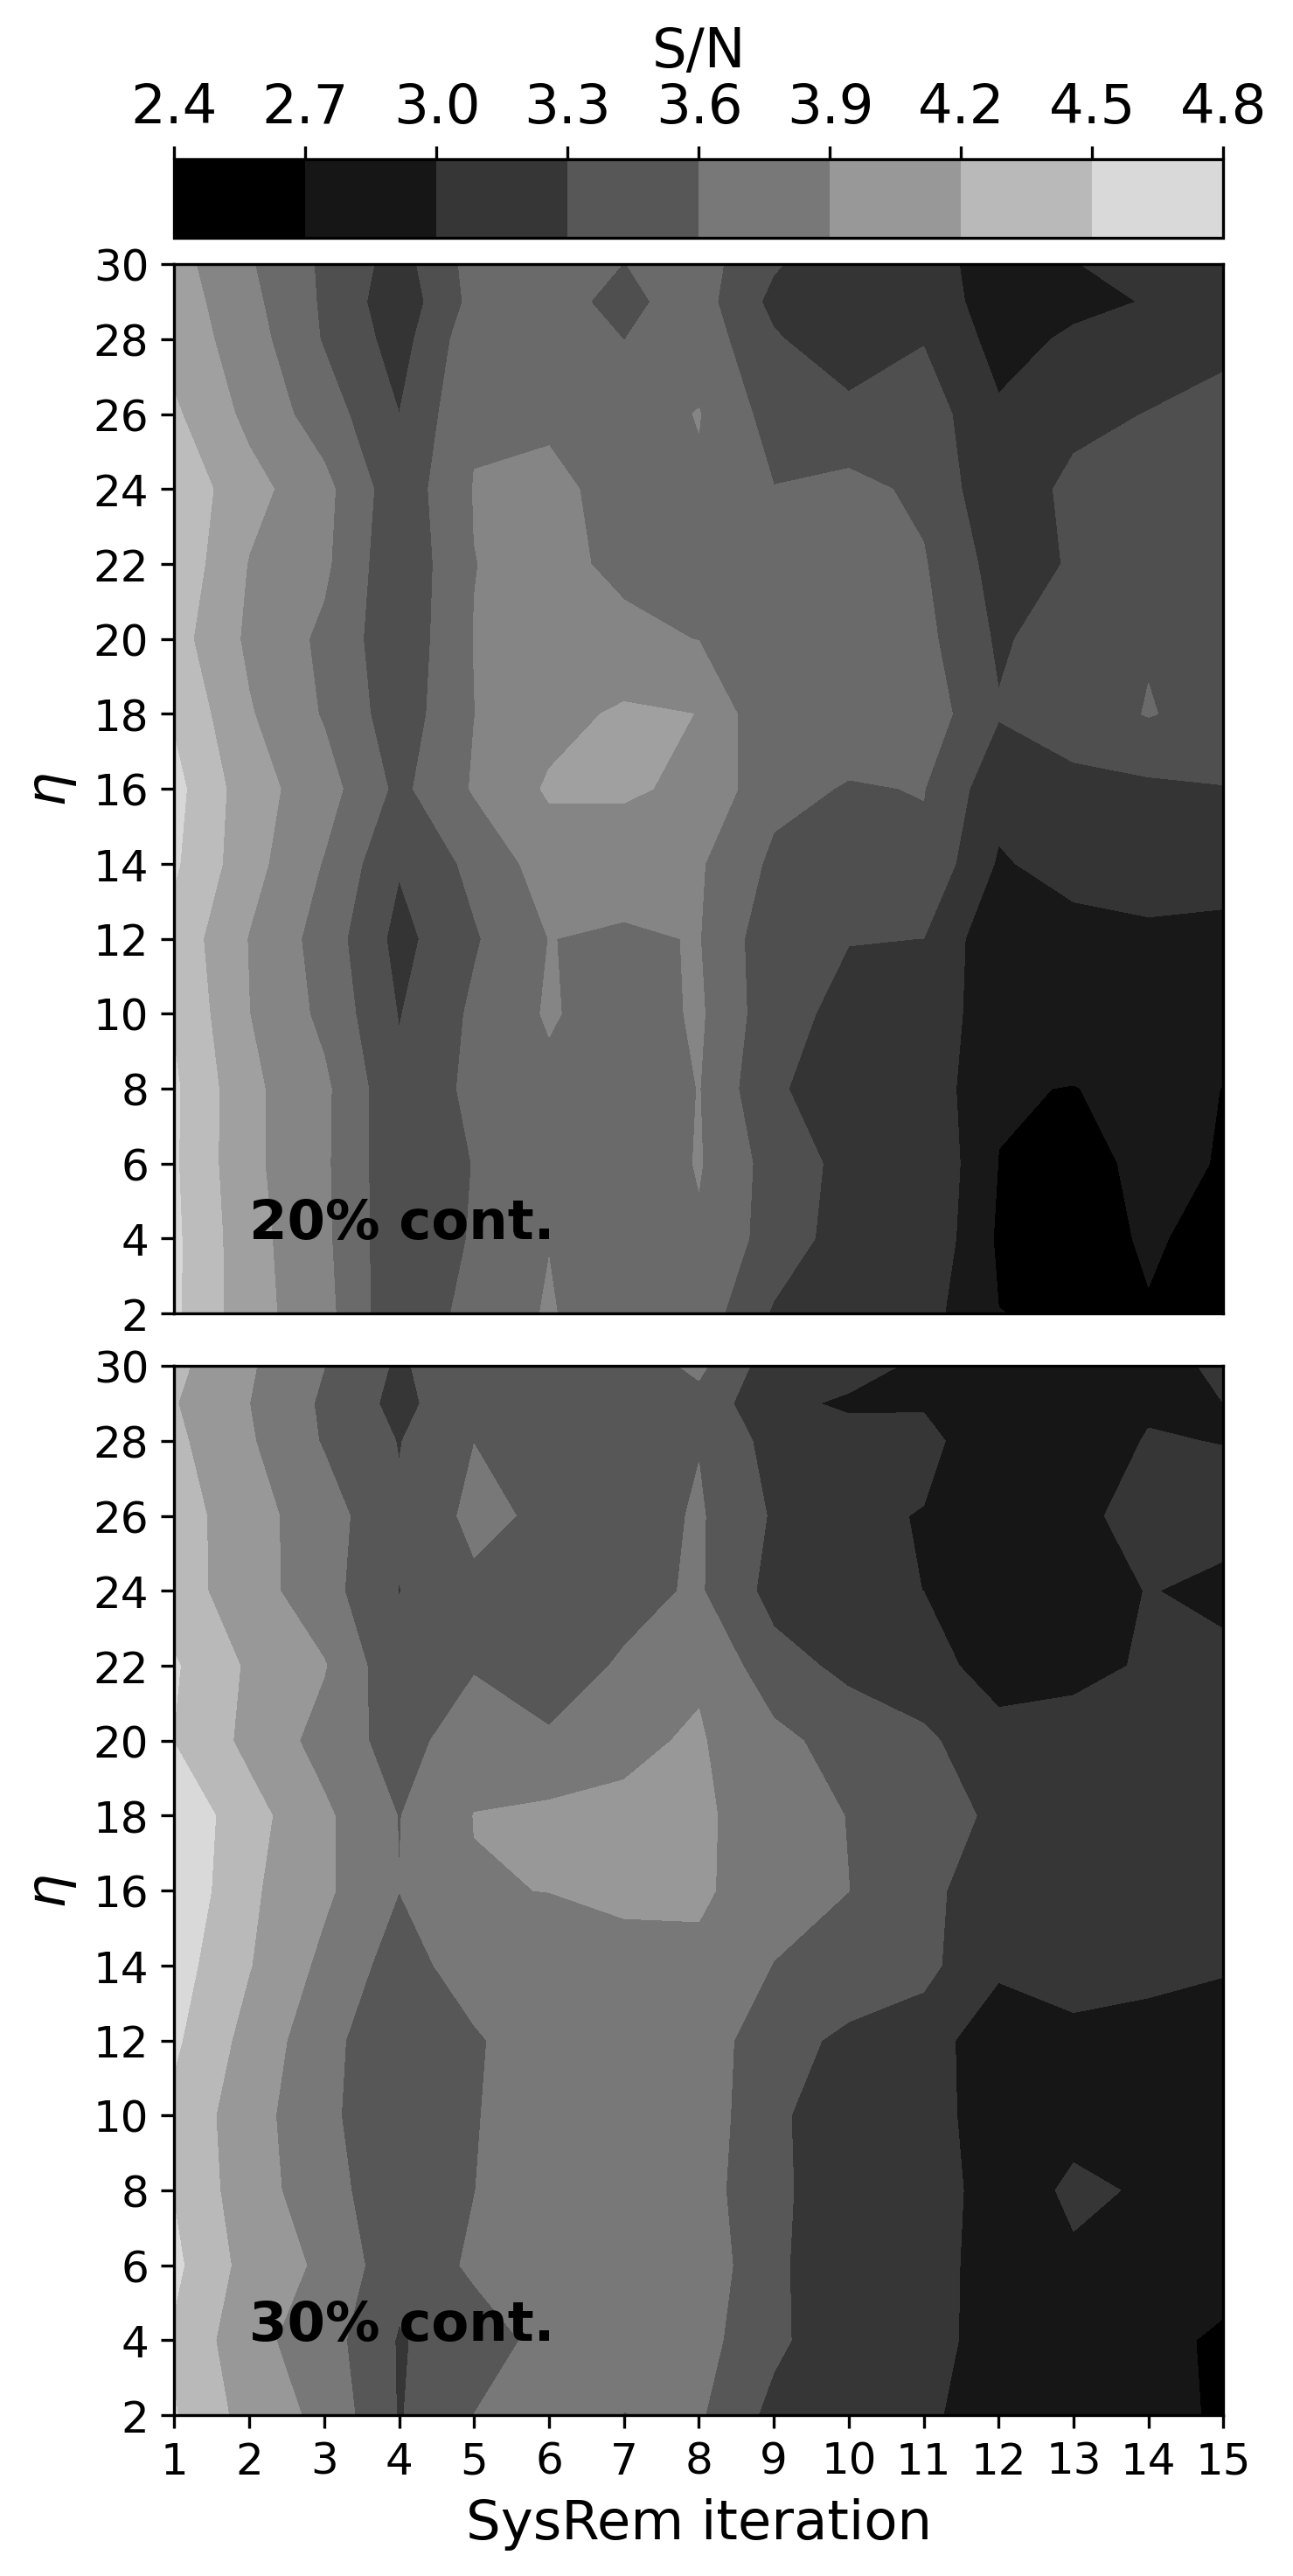

<Figure size 640x480 with 0 Axes>

In [7]:
sys_num = 15

fig = plt.figure(figsize=(10, 10),dpi=300)

lbl = 15
# fig.supxlabel(r'$V_{rest}$ (km/s)',x=0.83,y=-0.07,fontsize=lbl)

colorm = 'viridis'
cmap = plt.get_cmap(colorm)
cmap.set_bad(color = 'white', alpha = 1.)

axes_sig30 = [0, 0, 0.4, 0.4]
axes_sig20 = [0, 0+0.42, 0.4, 0.4]

sig30_ax = plt.axes(axes_sig30)
sig20_ax = plt.axes(axes_sig20)

SN_mapcolorbar = sig30_ax.contourf(np.arange(sys_num)+1,factel,sigeta30,vmin=np.min(sigeta20),vmax=5,cmap='gray')
sig30_ax.set_yticks([2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
sig30_ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
sig30_ax.set_ylabel(r'$\eta$',fontsize=lbl)
sig30_ax.set_xlabel('SysRem iteration',fontsize=lbl)
sig30_ax.text(2,4,"30% cont.",fontsize=15,weight='bold')
sig30_ax.tick_params(axis='both', which='major', labelsize=12)

sig20_ax.contourf(np.arange(sys_num)+1,factel,sigeta20,vmin=np.min(sigeta20),vmax=5,cmap='gray')
sig20_ax.set_yticks([2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
sig20_ax.set_xticks([])
sig20_ax.set_ylabel(r'$\eta$',fontsize=lbl)
# sig20_ax.set_xlabel('SysRem iteration',fontsize=lbl)
sig20_ax.text(2,4,"20% cont.",fontsize=15,weight='bold')
sig20_ax.tick_params(axis='both', which='major', labelsize=12)

p0 = sig30_ax.get_position().get_points().flatten()
p1 = sig20_ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.42+0.41, p1[2]-p0[0], 0.03])
cbar = plt.colorbar(SN_mapcolorbar, cax=ax_cbar,  orientation='horizontal',ticklocation='top',extend='both',extendfrac=0.01)
cbar.set_label('S/N',fontsize=lbl)
cbar.ax.tick_params(labelsize=lbl)
# cbar.ax.set_xticklabels(['low','med','high']) 

plt.savefig("figures/eta_param_vary.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show(block=False)
plt.clf()

In [14]:
sigeta20.max()

4.830511052554342